In [2]:
from chembench import load_data
from atommap import Extraction, Sanity
from net import AtomMapNet
from cbks import Reg_EarlyStoppingAndPerformance
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

np.random.seed(123)
tf.compat.v1.set_random_seed(123)

os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [3]:
df, index = load_data('ESOL')

loading dataset: ESOL number of split times: 3


In [4]:
train_idx, valid_idx, test_idx = index[0]

## check the smiles is valid or not

In [5]:
S = Sanity()
pd.Series(S.batch_is_valid(df.smiles)).sum()

100%|##########| 1128/1128 [00:01<00:00, 1048.11it/s]


1128

In [6]:
shape=(80, 80)
n_conformers = 2
epochs = 500
patience = 50
lr = 1e-4
batch_size = 64
loss = 'mse'
criteria = 'val_loss'

dense_layers = [128]
dense_avf = 'relu'
last_avf = 'linear'


In [7]:
E = Extraction()
X = E.batch_transform(df.smiles, include_hydrogen = False, n_conformers=n_conformers, n_jobs = 8, shape=shape)

100%|##########| 1128/1128 [00:27<00:00, 40.75it/s]


In [8]:
task= 'measured log solubility in mols per litre'

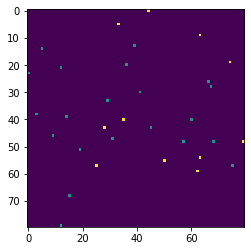

In [9]:
plt.imshow(X[0][0][:,:,-4])

In [10]:
Y = df[[task]]

In [11]:
trainX = X[train_idx]
trainY = Y.iloc[train_idx]

validX = X[valid_idx]
validY = Y.iloc[valid_idx]

testX = X[test_idx]
testY = Y.iloc[test_idx]

In [12]:
trainX = np.concatenate(trainX, axis = 0)
trainY = trainY.loc[trainY.index.repeat(n_conformers)][[task]].values

validX = np.concatenate(validX, axis = 0)
validY = validY.loc[validY.index.repeat(n_conformers)][[task]].values

testX = np.concatenate(testX, axis = 0)
testY = testY.loc[testY.index.repeat(n_conformers)][[task]].values

print(len(trainX), len(validX), len(testX))

1804 226 226


In [13]:
X.shape, Y.shape, trainX.shape

((1128, 2, 80, 80, 115), (1128, 1), (1804, 80, 80, 115))

In [16]:
model = AtomMapNet(input_shape = trainX.shape[1:], 
                   n_outputs=Y.shape[-1],
                   conv1_kernel_size = 5,
                   dense_layers = dense_layers,
                   dense_avf = dense_avf,
                   last_avf = last_avf,
                  )

In [17]:
model.count_params()

431969

In [1]:
pwd

'/home/sxh/Research/bidd-atommap/paper'

In [19]:
performance = Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                            (validX, validY),
                                            n_conformers = n_conformers,
                                            patience=patience, 
                                            criteria = criteria)

opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = opt, loss = loss)

In [20]:
model.fit(trainX, trainY, batch_size=batch_size, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performance]) 

epoch: 0001, loss: 5353.9821 - val_loss: 967.5308; rmse: 27.9728 - rmse_val: 28.9372;  r2: 0.0247 - r2_val: 0.0157                                                                                                    
epoch: 0002, loss: 394.3998 - val_loss: 283.4983; rmse: 11.2025 - rmse_val: 13.1123;  r2: 0.0012 - r2_val: 0.0012                                                                                                    
epoch: 0003, loss: 201.1903 - val_loss: 221.3855; rmse: 9.4715 - rmse_val: 11.2155;  r2: 0.0051 - r2_val: 0.0063                                                                                                    
epoch: 0004, loss: 155.8337 - val_loss: 192.0211; rmse: 8.8109 - rmse_val: 10.2937;  r2: 0.0165 - r2_val: 0.0176                                                                                                    
epoch: 0005, loss: 132.0952 - val_loss: 185.1760; rmse: 8.9169 - rmse_val: 10.2041;  r2: 0.0443 - r2_val: 0.0387                                 

KeyboardInterrupt: 

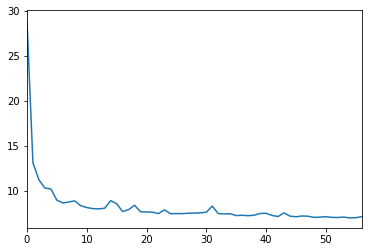

In [21]:
pd.DataFrame(performance.history)['val_rmse'].plot()

In [ ]:
performance.evaluate(validX, validY)

In [ ]:
performance.evaluate(testX, testY)